In [680]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [681]:
data = './hw2.csv'
day_dict = {'Sun': 1, 'Mon': 2, 'Tue': 3, 'Wed': 4, 'Thu': 5, 'Fri': 6, 'Sat': 7}

In [682]:
twitter_data = pd.read_csv(data)
twitter_data = twitter_data.replace('null;', 0)

In [683]:
twitter_data = twitter_data

In [684]:
twitter_data['Positive_sentiment'] = twitter_data['Sentiment'].str[0].astype(int)
twitter_data['Negative_sentiment'] = twitter_data['Sentiment'].str[2:4].astype(int)

In [685]:
twitter_data = twitter_data.drop(columns=['Sentiment', 'Entities'])

In [686]:
twitter_data['Tweet_day'] = twitter_data['Timestamp'].str[0:3]
twitter_data['Tweet_day'] = twitter_data['Tweet_day'].apply(lambda x: str(day_dict.get(x)))

In [687]:
twitter_data['Tweet_hour'] = twitter_data['Timestamp'].str[10:13].astype(int)

In [688]:
twitter_data['#Mentions'] = twitter_data['Mentions'].str.split()
twitter_data['#Mentions'] = twitter_data['#Mentions'].str.len()
twitter_data['#Mentions'] = twitter_data['#Mentions'].fillna(0)
twitter_data['#Mentions'] = twitter_data['#Mentions'].astype(int)

In [689]:
twitter_data['#Hashtags'] = twitter_data['Hashtags'].str.split()
twitter_data['#Hashtags'] = twitter_data['#Hashtags'].str.len()
twitter_data['#Hashtags'] = twitter_data['#Hashtags'].fillna(0)
twitter_data['#Hashtags'] = twitter_data['#Hashtags'].astype(int)

In [690]:

twitter_data

,Tweet ID,Username,Timestamp,#Followers,#Friends,#Retweets,#Favorites,Mentions,Hashtags,URLs,Positive_sentiment,Negative_sentiment,Tweet_day,Tweet_hour,#Mentions,#Hashtags
0,1178791787386814465,35234fe4a19cc1a3336095fb3780bcc1,Mon Sep 30 22:00:37 +0000 2019,619,770,0,0,0,0,0,2,-1,2,22,0,0
1,1178791985106153472,ea4592f39636d87af8fb4b17b7e2e4c0,Mon Sep 30 22:01:24 +0000 2019,36365,19344,13,17,0,0,https://twitter.com/himalayahawk/status/117766...,1,-4,2,22,0,0
2,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,Mon Sep 30 22:06:21 +0000 2019,5018,1933,0,0,0,0,https://goo.gl/fb/uoeiPk:-:,2,-1,2,22,0,0
3,1178795172206919680,eb8a99bca8945eab1d006750e9b75518,Mon Sep 30 22:14:04 +0000 2019,2219,971,0,0,0,0,0,2,-1,2,22,0,0
4,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,Mon Sep 30 22:26:32 +0000 2019,9009,4943,26,89,0,VFS,0,2,-1,2,22,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1179546502076796929,13e64b1c97e36d867d1c579a7dd1849c,Wed Oct 02 23:59:35 +0000 2019,41,193,0,0,cripplespur1,0,0,1,-1,4,23,1,0
99996,1179546574873141257,564b19153eb32b6a49167eea42d451f0,Wed Oct 02 23:59:53 +0000 2019,2011,1345,1,5,aii0l57❤️❤️❤️.,0,0,3,-1,4,23,1,0
99997,1179548305589755906,9f6a999aa613403742fd30afeadd9b6d,Thu Oct 03 00:06:45 +0000 2019,294,300,0,0,0,0,0,1,-1,5,0,0,0
99998,1179550507611906048,b14166b39b4bf8718f62f84dcad0b67d,Thu Oct 03 00:15:30 +0000 2019,169,116,0,0,0,ChicagoMed,0,1,-1,5,0,0,1


In [691]:
twitter_data['#Followers_log'] = np.log10(twitter_data['#Followers'] + 1)
twitter_data['#Friends_log'] = np.log10(twitter_data['#Friends'] + 1)
twitter_data['#Favorites_log'] = np.log10(twitter_data['#Favorites'] + 1)
twitter_data['#Mentions_log'] = np.log10(twitter_data['#Mentions'] + 1)
twitter_data['#Hashtags_log'] = np.log10(twitter_data['#Hashtags'] + 1)

Skew coefficient:  0.3799455766006705


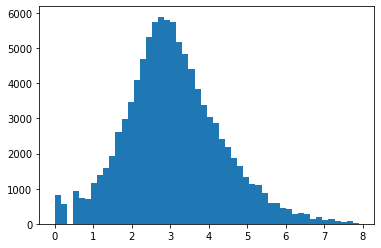

In [692]:
log_num_followers_hist = plt.hist(twitter_data['#Followers_log'], bins=50)
print('Skew coefficient: ', twitter_data['#Followers_log'].skew())

Skew coefficient:  -0.3130054049315858


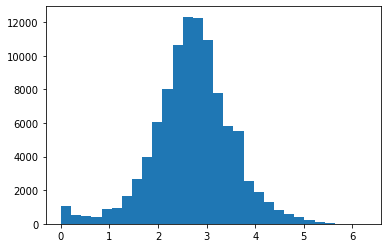

In [693]:
num_friends_hist = plt.hist(twitter_data['#Friends_log'], bins=30)
print('Skew coefficient: ', twitter_data['#Friends_log'].skew())

Skew coefficient:  1.3121065180212501


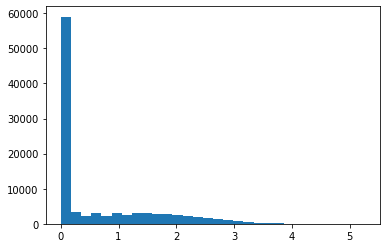

In [694]:
num_friends_hist = plt.hist(twitter_data['#Favorites_log'], bins=30)
print('Skew coefficient: ', twitter_data['#Favorites_log'].skew())

Skew coefficient:  2.0449340408016967


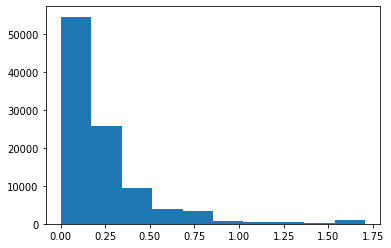

In [698]:
num_friends_hist = plt.hist(twitter_data['#Mentions_log'])
print('Skew coefficient: ', twitter_data['#Mentions_log'].skew())

Skew coefficient:  2.1402405394868054


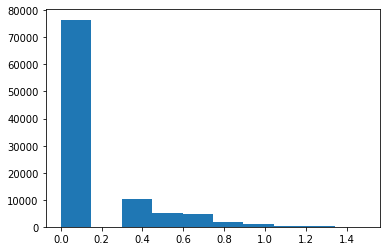

In [697]:
num_friends_hist = plt.hist(twitter_data['#Hashtags_log'])
print('Skew coefficient: ', twitter_data['#Hashtags_log'].skew())

In [699]:
td_new = twitter_data[['#Retweets', '#Followers', '#Friends', '#Favorites', '#Hashtags', '#Mentions', 'Positive_sentiment', 'Negative_sentiment', 'Tweet_day', 'Tweet_hour']].copy()
td_new

,#Retweets,#Followers,#Friends,#Favorites,#Hashtags,#Mentions,Positive_sentiment,Negative_sentiment,Tweet_day,Tweet_hour
0,0,619,770,0,0,0,2,-1,2,22
1,13,36365,19344,17,0,0,1,-4,2,22
2,0,5018,1933,0,0,0,2,-1,2,22
3,0,2219,971,0,0,0,2,-1,2,22
4,26,9009,4943,89,1,0,2,-1,2,22
...,...,...,...,...,...,...,...,...,...,...
99995,0,41,193,0,0,1,1,-1,4,23
99996,1,2011,1345,5,0,1,3,-1,4,23
99997,0,294,300,0,0,0,1,-1,5,0
99998,0,169,116,0,1,0,1,-1,5,0


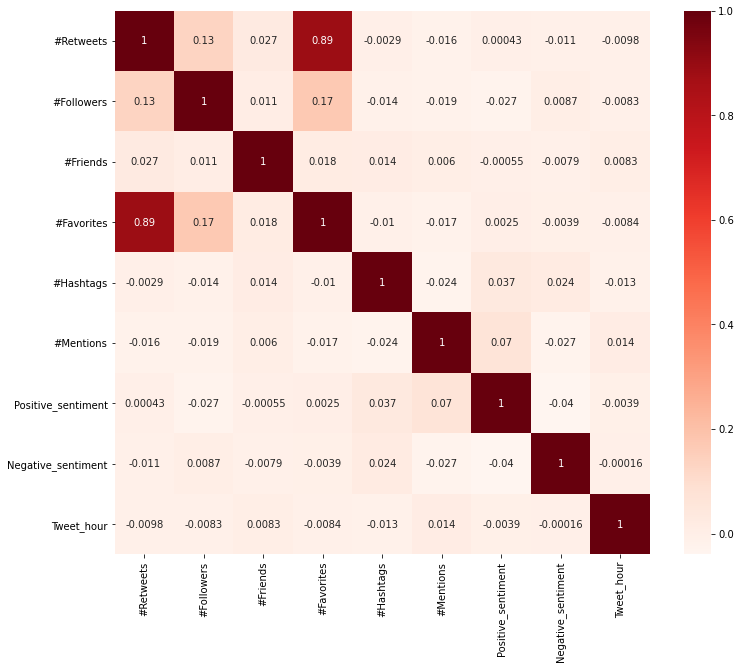

In [700]:
plt.figure(figsize=(12,10))
cor = td_new.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [701]:
x = twitter_data[['#Followers', '#Friends', '#Favorites', '#Hashtags', '#Mentions', 'Positive_sentiment', 'Negative_sentiment', 'Tweet_day', 'Tweet_hour']]
y = twitter_data['#Retweets']

In [702]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
model = LinearRegression()
model.fit(x_train, y_train)
pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])

,Coeff
#Followers,-0.000007
#Friends,0.000251
#Favorites,0.311673
#Hashtags,1.664976
#Mentions,0.029783
Positive_sentiment,-1.835999
Negative_sentiment,-2.861172
Tweet_day,0.000254
Tweet_hour,-0.201342


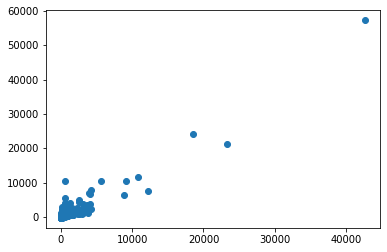

In [703]:
predictions = model.predict(x_test)
initial_model = plt.scatter(y_test, predictions)